# Bank loan model : The big picture


This case is about a bank (**Thera Bank**) which has a growing customer base.


Majority of these customers are **liability customers** (depositors) with varying size of deposits. The number of customers who are also borrowers (asset customers) is quite small, and **the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans**. 


In particular, the management wants to **explore ways of converting its liability customers to personal loan customers (while retaining them as depositors)**. 


A campaign that the bank ran last year for liability customers showed **a healthy conversion rate of over 9% success**. 


This has encouraged the retail marketing department to devise campaigns to better target marketing to increase the success ratio with a minimal budget.




## Framing the problem


### What is the business objective ?


The department wants to build a model that will **help them identify the potential customers who have a higher probability of purchasing the loan**. 

**This will increase the success ratio while at the same time reduce the cost of the campaign**.



### What is the type of learning ?



With the gathered information, we are ready to design our system.<br>

- This is a **supervised learning task** because the model can train on labeled examples (customers who actually purchased a loan). <br>


- It’s a **classification task** since the goal is to predict the likelihood of customers to purchase a loan or not. <br>



## Selecting a performance measure


The next step is to choose a performance measure. <br>

For our case, the main metric to use is the **recall** :   $$recall  = \frac{TP}{TP + FN}$$<br>
with **TP** : True Positives and **FN** : False Negatives



In machine learning, recall is a performance metric that measures the ability of a classification model to correctly identify all relevant instances of the positive class. <br>

It is particularly important in situations **where missing positive cases (false negatives) is more critical than incorrectly classifying negatives as positives**. <br>

In other words, we are interested in **detecting most of the customers that would purchase a loan** and **we accept a higher number of False Positive** detection.




Additionally, we will calculate : <br>
- the precision :  $$precision  = \frac{TP}{TP + FP}$$ <br>

- the F1 score :    $$F_1  = \frac{2}{\frac{1}{precision}+ \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP +  \frac{FN + FP}{2}} $$ <br><br>


with **TP** : True Positives and **FN** : False Negatives


In machine learning, **precision** is a metric used to evaluate the performance of a classification model, especially in cases where the classes are imbalanced or when the cost of false positives is high.<br>
Precision focuses on the proportion of correctly identified positive instances out of all instances that were predicted as positive.

The **F1 score** is a performance metric used in machine learning to evaluate the accuracy of a classification model, especially when dealing with imbalanced datasets. <br>
It is the harmonic mean of precision and recall, providing a single score that balances the trade-off between them.


# Getting the data


## Import libraries


Here will be imported all the necessary libraries that we'll use for this task !

In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

# General libraries
import pandas as pd
import numpy as np
import math

# Visualization
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import plotly.express as px

# Split train set and test set
from sklearn.model_selection import train_test_split

# Geolocation libraries
import pgeocode 
from geopy.geocoders import Nominatim

## Import the data


We import the data and store it locally.

In [2]:
# Retrieve the data stored locally
path = "../data/raw_data"
banking_data = pd.read_excel(path + "/Bank_Personal_Loan_Modelling.xlsx", sheet_name="Data")

banking_data.head()

ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

In [3]:
banking_data.shape

(5000, 14)

## Describe the features


We have the following features : <br>
**ID**: Customer ID<br>
**Age**: Customer's age in completed years<br>
**Experience**: #years of professional experience<br>
**Income**: Annual income of the customer (**in thousands of dollars**) <br>
**ZIP_Code**: Home Address ZIP code.<br>
**Family**: Family size of the customer <br>
**CCAvg**: Avg. spending on credit cards per month (**in thousands of dollars**)<br>
**Education**: Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional<br>
**Mortgage**: Value of house mortgage if any (**in thousands of dollars**).<br>
**Personal Loan**: Did this customer accept the personal loan offered in the last campaign?<br>
**Securities Account**: Does the customer have a securities account with the bank?<br>
**CD Account**: Does the customer have a certificate of deposit (CD) account with the bank?<br>
**Online**: Does the customer use internet banking facilities?<br>
**CreditCard**: Does the customer use a credit card issued by UniversalBank?<br>



## Rewrite feature names


Updating the feature names for easier use.


In [4]:
# Updating the feature names for easier use.
banking_data = banking_data.rename(columns={
                                            "ZIP Code":"ZIP_Code", 
                                            "Personal Loan":"Personal_Loan",
                                            "Securities Account":"Securities_Account",
                                            "CD Account": "CD_Account"
                                            })

banking_data.head(2)

ID  Age  Experience  Income  ZIP_Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0

## Dropping features


We won't need the ID column. Let's drop it !


In [5]:
# We won't need the ID column. Let's drop it !
banking_data = banking_data.drop(columns=['ID'])
banking_data.head(2)

Age  Experience  Income  ZIP_Code  Family  CCAvg  Education  Mortgage  \
0   25           1      49     91107       4    1.6          1         0   
1   45          19      34     90089       3    1.5          1         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0

## Cleaning the data

### Processing duplicates

We check the number of duplicated rows.

In [6]:
# Check number of rows before removing duplicates
print(f"Number of rows : {len(banking_data)}")

# Compute the number of duplicated rows
print(f"Number of duplicated rows : {banking_data.duplicated().sum()}")

# Remove duplicates
banking_data = banking_data.drop_duplicates() 

# Check number of rows before removing duplicates
print(f"Number of rows (AFTER dropping duplicates) : {len(banking_data)}")

Number of rows : 5000
Number of duplicated rows : 0
Number of rows (AFTER dropping duplicates) : 5000


## Processing missing data



We check the percentage of missing values in the data at hand.

In [7]:
def get_missing_data(data):       
    # Counting the percentage of NaN for each column
    missing_data = data.isnull().sum().sort_values(ascending=False)/len(data)*100 #NaN percentage for each column

    # missing_data
    missing_data = missing_data[missing_data > 0]

    #Missing data column names
    missing_cols = missing_data.index.values.tolist()

    #Show missing data in percent
    return missing_data

missing_data = get_missing_data(banking_data)
missing_data


Series([], dtype: float64)

We don't have missing values.


# Exploring the data


## Quick exploration

In [8]:
# summary of the DataFrame
banking_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIP_Code            5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal_Loan       5000 non-null   int64  
 9   Securities_Account  5000 non-null   int64  
 10  CD_Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 546.9 KB


In [9]:
# Descriptive statistics
banking_data.describe()

Age   Experience       Income      ZIP_Code       Family  \
count  5000.000000  5000.000000  5000.000000   5000.000000  5000.000000   
mean     45.338400    20.104600    73.774200  93152.503000     2.396400   
std      11.463166    11.467954    46.033729   2121.852197     1.147663   
min      23.000000    -3.000000     8.000000   9307.000000     1.000000   
25%      35.000000    10.000000    39.000000  91911.000000     1.000000   
50%      45.000000    20.000000    64.000000  93437.000000     2.000000   
75%      55.000000    30.000000    98.000000  94608.000000     3.000000   
max      67.000000    43.000000   224.000000  96651.000000     4.000000   

             CCAvg    Education     Mortgage  Personal_Loan  \
count  5000.000000  5000.000000  5000.000000    5000.000000   
mean      1.937913     1.881000    56.498800       0.096000   
std       1.747666     0.839869   101.713802       0.294621   
min       0.000000     1.000000     0.000000       0.000000   
25%       0.700000     1.000000     0.000000       0.000000   
50%       1.500000     2.000000     0.000000       0.000000   
75%       2.500000     3.000000   101.000000       0.000000   
max      10.000000     3.000000   635.000000       1.000000   

       Securities_Account  CD_Account       Online   CreditCard  
count         5000.000000  5000.00000  5000.000000  5000.000000  
mean             0.104400     0.06040     0.596800     0.294000  
std              0.305809     0.23825     0.490589     0.455637  
min              0.000000     0.00000     0.000000     0.000000  
25%              0.000000     0.00000     0.000000     0.000000  
50%              0.000000     0.00000     1.000000     0.000000  
75%              0.000000     0.00000     1.000000     1.000000  
max              1.000000     1.00000     1.000000     1.000000

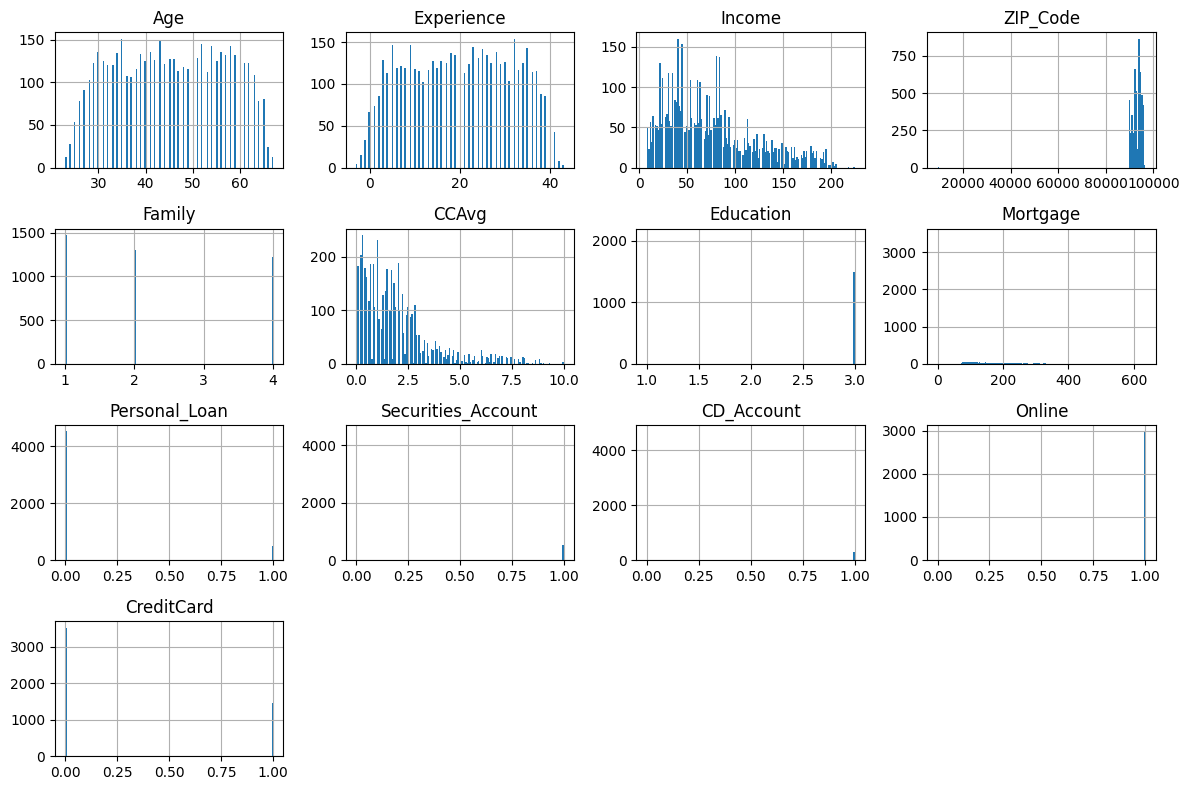

In [10]:
# Histogram of the DataFrame’s columns
banking_data.hist(bins=150, figsize=(12, 8))
plt.tight_layout()
plt.show()

## Test set and train set

### Check target balance


Our target is **Personal_Loan**. <br> 
Let's check the balance of the target.


In [11]:
# Our target is Personal_Loan. Let's check the balance of the target.
banking_data.Personal_Loan.value_counts()/len(banking_data)*100

0    90.4
1     9.6
Name: Personal_Loan, dtype: float64

Less than 10% of customers accepted the personal loan offered in the last campaign. <br>
We'll need to stratify the test set and the train set to have the same proportions of labels. 


### Train set and test set: Stratification



We split the data in : <br>
- a train on which we will train our final model
- a test set we will use to evaluate the model (in the end)

In [12]:
# Create train set and test set (stratified based on median incom categories)
strat_train_set, strat_test_set = train_test_split(
    banking_data, test_size=0.2, stratify=banking_data["Personal_Loan"], random_state=42)

In [13]:
# Check of stratified train set
strat_train_set.Personal_Loan.value_counts()/len(strat_train_set)*100

0    90.4
1     9.6
Name: Personal_Loan, dtype: float64

In [14]:
# Check of stratified test set
strat_test_set.Personal_Loan.value_counts()/len(strat_test_set)*100

0    90.4
1     9.6
Name: Personal_Loan, dtype: float64

## Explore and visualizing the data to gain insights


In [15]:
# Create a copy of the stratified train set before exploring
bank = strat_train_set.copy()

Let's save the explorated data as CSV file (used for exploration purpose in Google Looker Studio).


In [16]:
# # Let's save the explorated data as CSV file (used for exploration purpose in Google Looker Studio).
# path_save = "../data/processed_data/strat_train_set.csv"
# bank.to_csv(path_save, index=False)

Let's look at the type of the features !


In [17]:
# Type of features 
continuous_feats = ['CCAvg']
discrete_feats = ['Age', 'Experience', 'Income', 'Mortgage']
categorical_feats = ['Education','Personal_Loan', 'Family', 'ZIP_Code']
binary_feats = ['Securities_Account','CD_Account','Online','CreditCard']

### Univariate analysis


#### Numerical features



In [18]:
# Numerical features
numerical_feats = continuous_feats + discrete_feats
numerical_feats

['CCAvg', 'Age', 'Experience', 'Income', 'Mortgage']

In [19]:
bank.head()

Age  Experience  Income  ZIP_Code  Family  CCAvg  Education  Mortgage  \
408    60          36      89     91745       2    2.8          1         0   
3737   44          19      30     91423       1    0.5          3         0   
3889   26           0      19     93014       1    0.1          2       121   
568    34           9      41     92101       2    0.1          1       161   
1041   56          32      51     92780       4    1.5          1         0   

      Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  
408               0                   0           0       1           0  
3737              0                   0           0       1           0  
3889              0                   0           0       1           0  
568               0                   0           0       1           1  
1041              0                   0           0       0           0

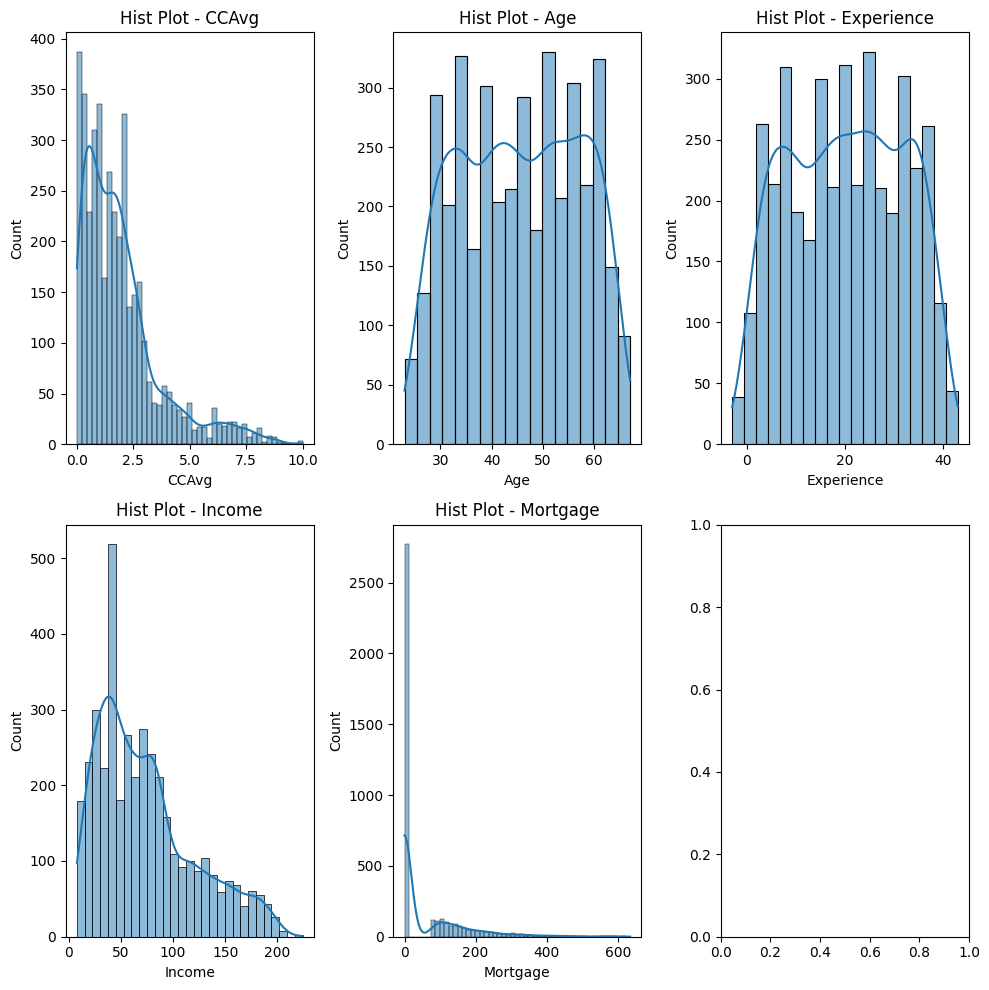

In [20]:
# Plot histograms
ncol_max = 3
nrow_max = round(len(bank[numerical_feats].columns)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))


# Flatten axes for easy iteration
axs = axs.flatten()

# Histograms
for col in bank[numerical_feats].columns:  
        # Plotting the histograms
        sns.histplot(data = bank[numerical_feats], 
                     x= bank[col], 
                     kde = True,                                   
                     ax=axs[bank[numerical_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[numerical_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[numerical_feats].columns.get_loc(col)].set_title(f'Hist Plot - {col}')  

# Adjust layout
plt.tight_layout()
plt.show()

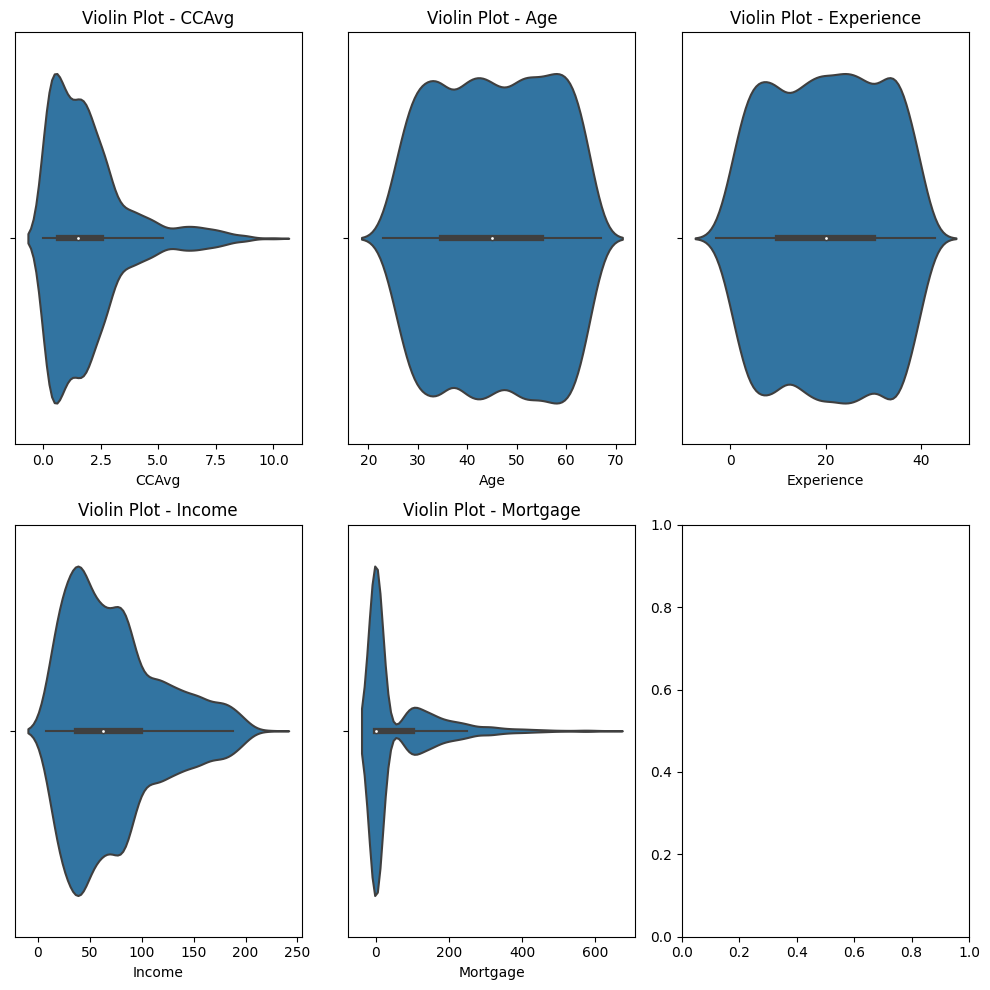

In [21]:
# Plot violin plots
ncol_max = 3
nrow_max = round(len(bank[numerical_feats].columns)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))


# Flatten axes for easy iteration
axs = axs.flatten()

# boxplots
for col in bank[numerical_feats].columns:  
        # Plotting the violin plots
        sns.violinplot(data = bank[numerical_feats], 
                     x= bank[col],                                   
                     ax=axs[bank[numerical_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[numerical_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[numerical_feats].columns.get_loc(col)].set_title(f'Violin Plot - {col}')  

# Adjust layout
plt.tight_layout()
plt.show()


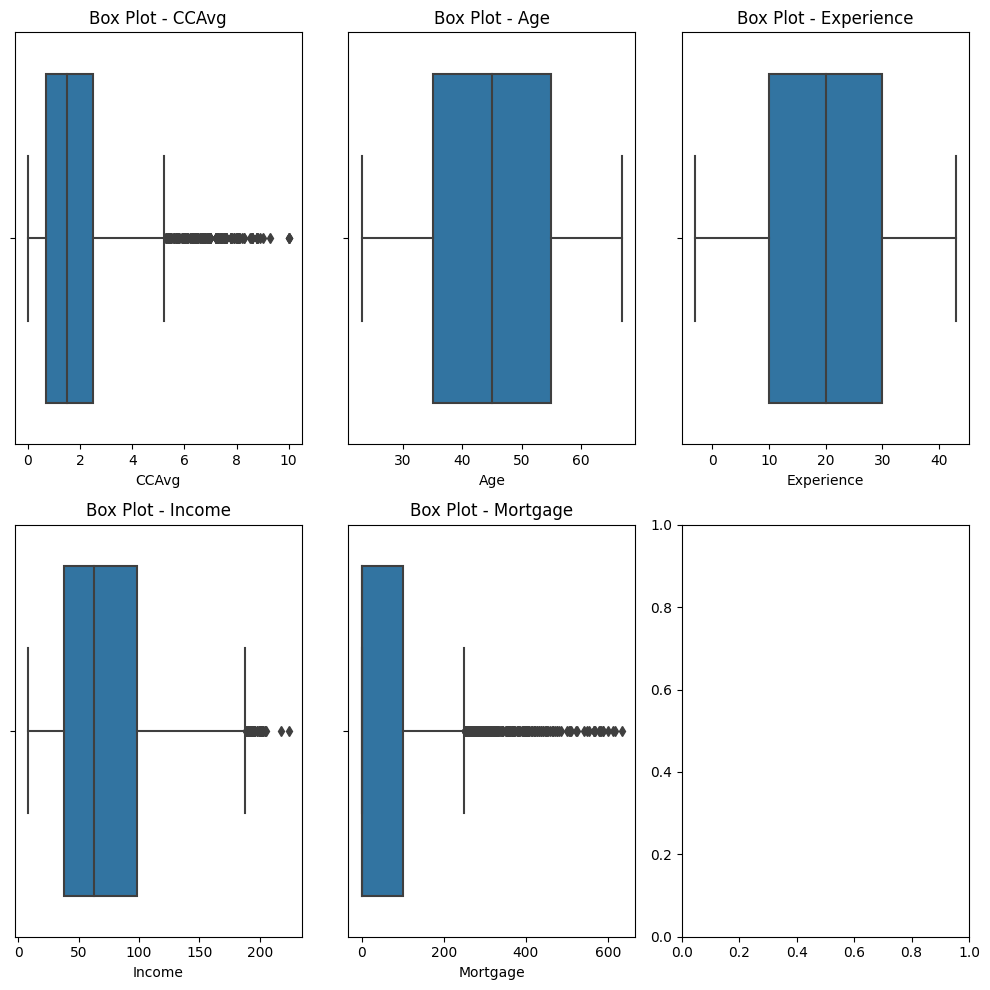

In [22]:
# Plot boxplots
ncol_max = 3
nrow_max = round(len(bank[numerical_feats].columns)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))


# Flatten axes for easy iteration
axs = axs.flatten()

# boxplots
for col in bank[numerical_feats].columns:  
        # Plotting the boxplots
        sns.boxplot(data = bank[numerical_feats], 
                     x= bank[col],                                   
                     ax=axs[bank[numerical_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[numerical_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[numerical_feats].columns.get_loc(col)].set_title(f'Box Plot - {col}')  

# Adjust layout
plt.tight_layout()
plt.show()



**Insights** :

- CCAvg : The median spending on credit card per month is **around 1500 USD**.
- Age : The median age is **around 45 years old**.
- Experience : The median number of years of professional experience is **around 20 years**.
- Income : The median income is around **70 000 USD**.


#### Categorical features



In [23]:
# Categorical features
# categorical_feats = ['Education','Personal_Loan', 'Family']
# binary_feats = ['Securities_Account','CD_Account','Online','CreditCard']

categories_feats = categorical_feats + binary_feats
categories_feats

['Education',
 'Personal_Loan',
 'Family',
 'ZIP_Code',
 'Securities_Account',
 'CD_Account',
 'Online',
 'CreditCard']

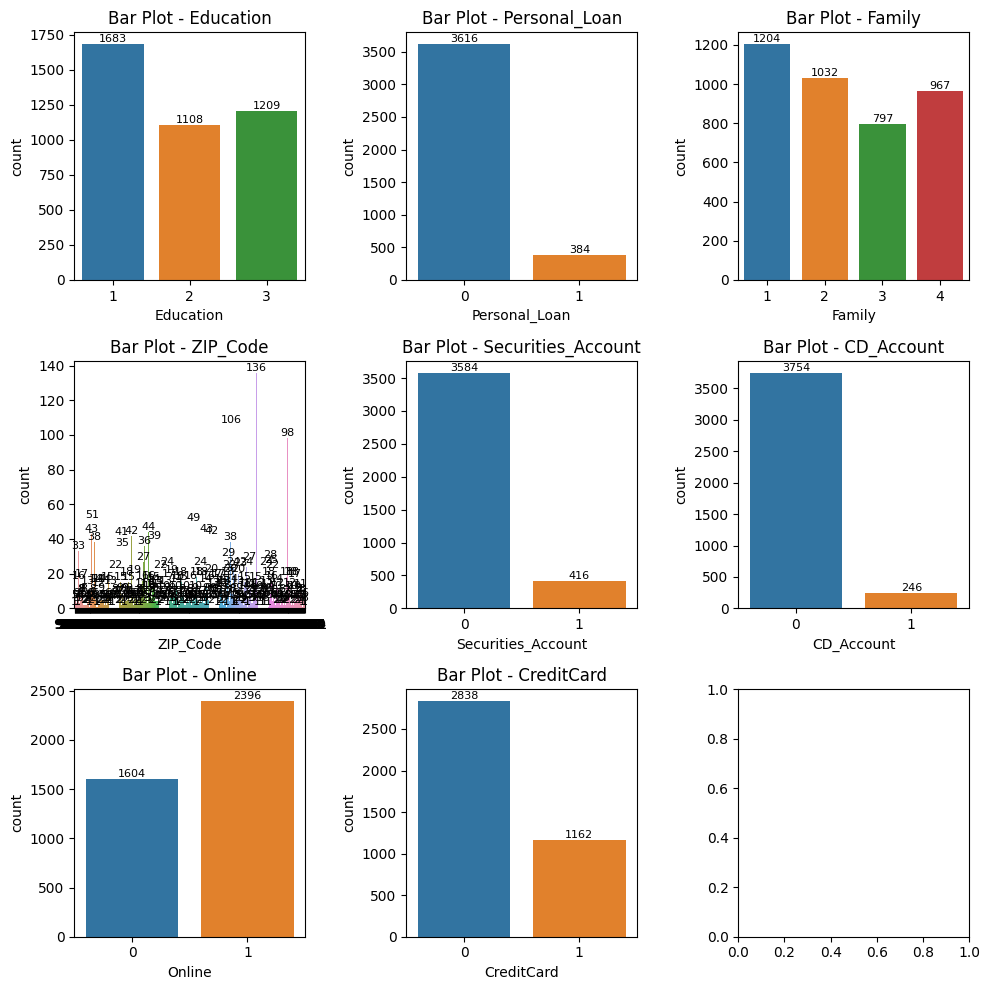

In [24]:
# Plot count plots
ncol_max = 3
nrow_max = math.ceil(len(bank[categories_feats].columns)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))

# Flatten axes for easy iteration
axs = axs.flatten()

# boxplots
for col in bank[categories_feats].columns:  
        # Plotting the count plots
        sns.countplot(data = bank[categories_feats], 
                     x= bank[col],                                   
                     ax=axs[bank[categories_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[categories_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[categories_feats].columns.get_loc(col)].set_title(f'Bar Plot - {col}')  
        axs[bank[categories_feats].columns.get_loc(col)].bar_label(            
            axs[bank[categories_feats].columns.get_loc(col)].containers[0],
            fontsize=8
            )                        

            
# Adjust layout
plt.tight_layout()
plt.show()

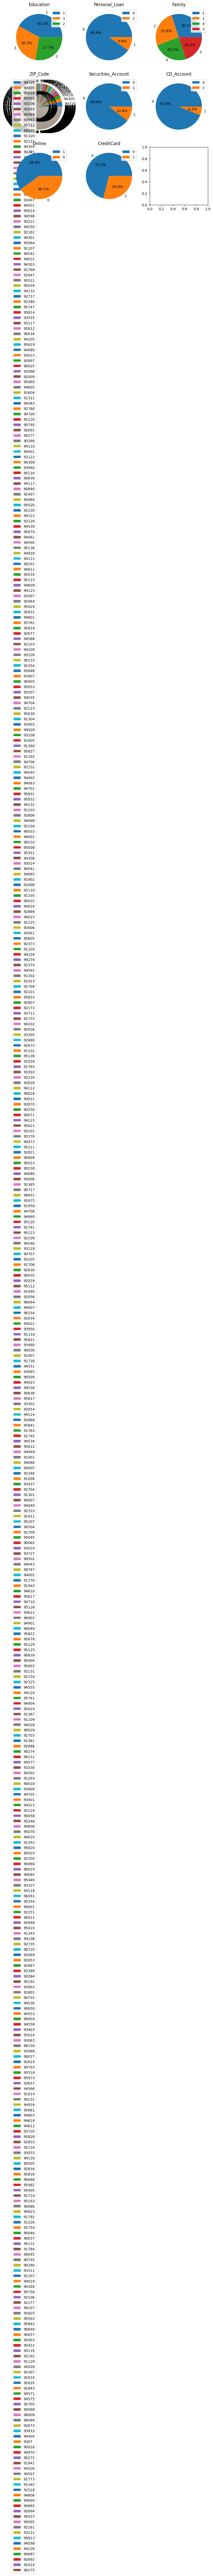

In [25]:
# Plot pie charts
ncol_max = 3
nrow_max = math.ceil(len(bank[categories_feats].columns)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))

# Flatten axes for easy iteration
axs = axs.flatten()

# boxplots
for col in bank[categories_feats].columns:  
        # Example DataFrame
        data = pd.DataFrame({'Category': bank[col].value_counts().index.values, 
                             'Values': bank[col].value_counts().values})

        # Create a pie chart
        data.set_index('Category').plot.pie(y='Values',
                                            autopct='%1.1f%%', 
                                            ax = axs[bank[categories_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[categories_feats].columns.get_loc(col)].set_title(f'{col}') 
        axs[bank[categories_feats].columns.get_loc(col)].set_ylabel('')              

            
# Adjust layout
plt.tight_layout()
plt.show()


### Bivariate analysis


#### Correlation


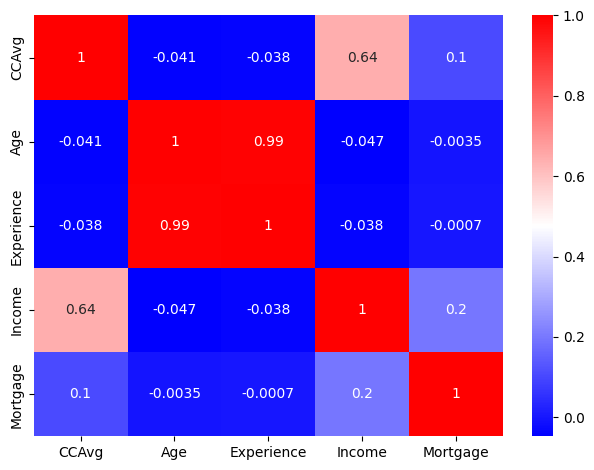

In [26]:
# Heatmap of pairwise correlations
correlation_matrix = bank[numerical_feats].corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, 
            xticklabels=column_names, 
            yticklabels=column_names,
            cmap= "bwr",
           annot=True);
plt.tight_layout()
plt.show()

In [27]:
#Create a dataframe listing pair correlations and absolute correlations
correlation_matrix = bank[numerical_feats].corr()

# Converting the correlation matrix into a DataFrame
corr_df = correlation_matrix.stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

corr_df.sort_values(by="absolute_correlation", ascending=False, inplace = True)
corr_df.head(10)


feature_1   feature_2  correlation  absolute_correlation
7          Age  Experience     0.994134              0.994134
11  Experience         Age     0.994134              0.994134
15      Income       CCAvg     0.641669              0.641669
3        CCAvg      Income     0.641669              0.641669
23    Mortgage      Income     0.197115              0.197115
19      Income    Mortgage     0.197115              0.197115
4        CCAvg    Mortgage     0.104534              0.104534
20    Mortgage       CCAvg     0.104534              0.104534
8          Age      Income    -0.047440              0.047440
16      Income         Age    -0.047440              0.047440

We see that Experience and Age have **more than 99% correlation**.<br>
We may drop one of these later on.


#### Scatter matrix


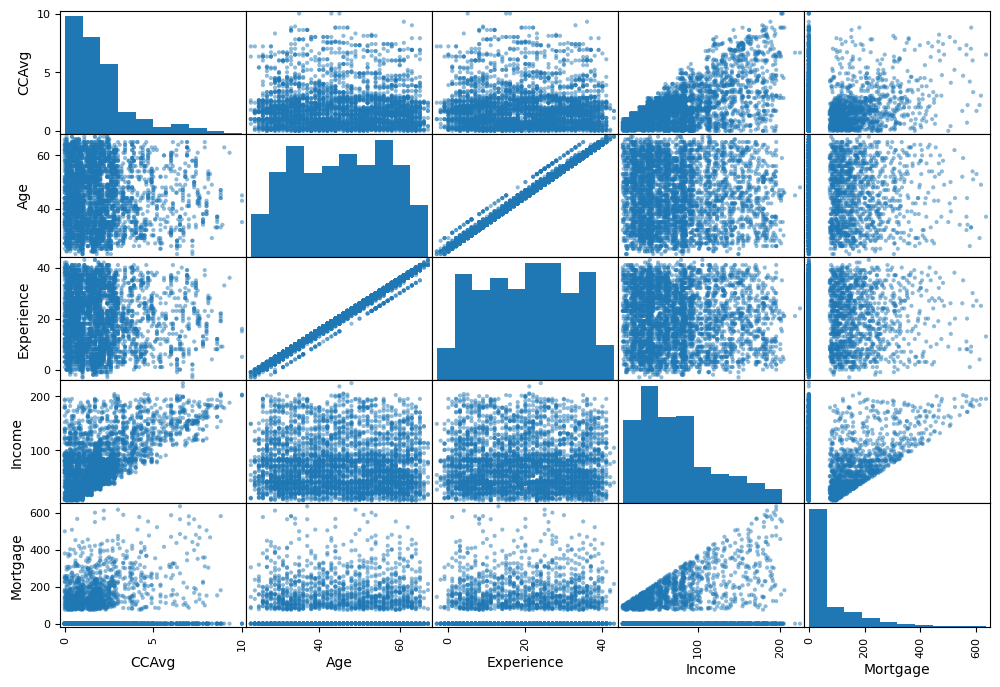

In [28]:
# Display scatter matrix for numerical
scatter_matrix(bank[numerical_feats], figsize= (12,8))
plt.show()

### Visualizing Geographical data


In [29]:
# Retrieve geographical info from zip code
ZIP_Codes = banking_data['ZIP_Code'].values.astype('str').tolist()
nomi = pgeocode.Nominatim('us')
df_PostalCode = nomi.query_postal_code(ZIP_Codes)
df_PostalCode['postal_code'] = df_PostalCode['postal_code'].values.astype('int64')

# Check
print(df_PostalCode.shape)
df_PostalCode.head()


(5000, 12)


postal_code country_code     place_name  state_name state_code  \
0        91107           US       Pasadena  California         CA   
1        90089           US    Los Angeles  California         CA   
2        94720           US       Berkeley  California         CA   
3        94112           US  San Francisco  California         CA   
4        91330           US     Northridge  California         CA   

                        county_name  county_code community_name  \
0                       Los Angeles         37.0            NaN   
1                       Los Angeles         37.0            NaN   
2                           Alameda          1.0            NaN   
3  City and County of San Francisco         75.0            NaN   
4                       Los Angeles         37.0            NaN   

   community_code  latitude  longitude  accuracy  
0             NaN   34.1510  -118.0889       4.0  
1             NaN   33.7866  -118.2987       4.0  
2             NaN   37.8738  -122.2549       4.0  
3             NaN   37.7195  -122.4411       4.0  
4             NaN   34.2283  -118.5368       4.0

In [30]:
# Check number of rows before removing duplicates
print(f"Number of rows : {len(df_PostalCode)}")

# Compute the number of duplicated rows
print(f"Number of duplicated rows : {df_PostalCode.duplicated().sum()}")

# Remove duplicates
df_PostalCode = df_PostalCode.drop_duplicates() 

# Check number of rows before removing duplicates
print(f"Number of rows (AFTER dropping duplicates) : {len(df_PostalCode)}")

Number of rows : 5000
Number of duplicated rows : 4533
Number of rows (AFTER dropping duplicates) : 467


In [31]:
# Create latitude and longitude columns
bank = pd.merge(bank,df_PostalCode[['postal_code', 'latitude', 'longitude']],
                        how='left',
                        left_on='ZIP_Code',
                        right_on='postal_code')

# Dropping postal_code (not needed anymore)
bank = bank.drop(columns='postal_code')

# Check
print(bank.shape)
bank.head(5)


(4000, 15)


Age  Experience  Income  ZIP_Code  Family  CCAvg  Education  Mortgage  \
0   60          36      89     91745       2    2.8          1         0   
1   44          19      30     91423       1    0.5          3         0   
2   26           0      19     93014       1    0.1          2       121   
3   34           9      41     92101       2    0.1          1       161   
4   56          32      51     92780       4    1.5          1         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  \
0              0                   0           0       1           0   
1              0                   0           0       1           0   
2              0                   0           0       1           0   
3              0                   0           0       1           1   
4              0                   0           0       0           0   

   latitude  longitude  
0   33.9977  -117.9652  
1   34.1526  -118.4322  
2   34.3989  -119.5185  
3   32.7185  -117.1593  
4   33.7364  -117.8229

**Let's check for missing data after creating longitude and latitude features!** 




In [32]:
missing_data = get_missing_data(bank)
missing_data

latitude     0.925
longitude    0.925
dtype: float64

In [33]:
# Visualize geographic data using scatter_mapbox
fig = px.scatter_mapbox(bank, 
                         lat='latitude', 
                         lon='longitude', 
                         hover_data=['ZIP_Code'],
                         center=dict(lat=37, lon=-120),
                         size_max=20,
                         zoom=4,
                         # size='Personal_Loan',
                         color='Personal_Loan',
                         height=600,
                         title='<b> Visualize geographic data using scatter_mapbox</b>',
                         color_continuous_scale=px.colors.sequential.Viridis)

fig.update_layout(mapbox_style='open-street-map', height=600)
fig.show()

# Prepare the data for Machine Learning Algorithms


We separate the features from the target.

In [34]:
# Separate featues from target
X = strat_train_set.drop("Personal_Loan", axis=1)
y = strat_train_set["Personal_Loan"].copy()

In [35]:
# Display the shapes of features and target
print(f"The shape of X : {X.shape}")
print(f"The shape of y : {y.shape}")

The shape of X : (4000, 12)
The shape of y : (4000,)


In [36]:
# Numerical features
numerical_feats = continuous_feats + discrete_feats

# Categorical features
categorical_feats = ['Education', 'Family']
binary_feats = ['Securities_Account','CD_Account','Online','CreditCard']

# Display
print(f"numerical_feats : {numerical_feats}")
print(f"categorical_feats : {categorical_feats}")
print(f"binary_feats : {binary_feats}")     

numerical_feats : ['CCAvg', 'Age', 'Experience', 'Income', 'Mortgage']
categorical_feats : ['Education', 'Family']
binary_feats : ['Securities_Account', 'CD_Account', 'Online', 'CreditCard']
